### Instrucciones generales <a class="tocSkip"></a>

1. Forme un grupo de **máximo dos estudiantes**
1. Versione su trabajo usando un **repositorio <font color="red">privado</font> de github**. Agregue a su compañero y a su profesor (usuario github: phuijse) en la pestaña *Settings/Manage access*. No se aceptarán consultas si la tarea no está en github. No se evaluarán tareas que no estén en github.
1. Se evaluará el **resultado, la profundidad de su análisis y la calidad/orden de sus códigos** en base al último commit antes de la fecha y hora de entrega". Se bonificará a quienes muestren un método de trabajo incremental y ordenado según el histórico de *commits*
1. Sean honestos, ríganse por el [código de ética de la ACM](https://www.acm.org/about-acm/code-of-ethics-in-spanish)



# Tarea 3: Predicción de una serie de tiempo caótica

En esta tarea se pide entrenar y evaluar un predictor para el sistema no-lineal [Mackey-Glass](https://en.wikipedia.org/wiki/Mackey-Glass_equations)

Esta serie de tiempo se obtiene de la solución de la siguiente ecuación diferencial

$$
\frac{dy}{dt} = \beta \frac{ y(t-\tau)}{1 + y(t-\tau)^{n}} - \gamma y(t),
$$

donde el parámetro $\tau$ controla el comportamiento dinámico de la serie de tiempo 

En esta tarea nos limitaremos en estudiar el caso con $n=10$, $\gamma = 0.1$ y $\beta = 0.2$

El valor del parámetro $\tau$ modifica el comportamiento dinámico del sistema, en particular se tiene que

- $\tau = 17$ el sistema tiene un comportamiento debilmente caótico
- $\tau = 30$ el sistema tiene un comportamiento fuertemente caótico

La ecuación de diferencial anterior fue propuesta por Michael Mackey and Leon Glass en 1977 como modelo para procesos fisiológicos asociados a la [homeostasis](https://es.wikipedia.org/wiki/Homeostasis)

El código adjunto a esta tarea genera la serie de tiempo en función 

Se generan 1000 muestras de la serie de tiempo. Use los primeros 500 puntos para entrenar, los siguientes 250 puntos para calibrar los hiperparámetros y los últimos 250 para evaluar y comparar los filtros

<IPython.core.display.Javascript object>


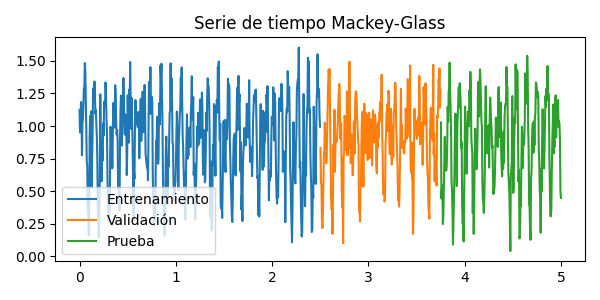

In [296]:
import numpy as np
%matplotlib notebook
import matplotlib.pylab as plt
from mackey import MackeyGlass

# Puede calcular el error medio cuadrático normalizado usando:
NMSE = lambda y, yhat : np.sum((y - yhat)**2)/np.var(y)



# Gráfico
(t_train, y_train), (t_valid, y_valid), (t_test, y_test) = MackeyGlass(tau=30.)
fig, ax = plt.subplots(figsize=(6, 3), tight_layout=True)
ax.plot(t_train, y_train, label='Entrenamiento')
ax.plot(t_valid, y_valid, label='Validación')
ax.plot(t_test, y_test, label='Prueba')
ax.set_title('Serie de tiempo Mackey-Glass');
ax.legend();


## (45%) Predicción con algoritmo LMS

1. Describa en detalle el algoritmo LMS e implemente un predictor a un paso basado en el **algoritmo LMS normalizado**

In [298]:
class Filtro_NLMS:
    
    def __init__(self, L, mu, delta=1e-6, winit=None):
        self.L = L
        self.w = np.zeros(L)
        self.mu = mu
        self.delta = delta
        
    def update(self, un, dn):
        unorm = np.dot(un, un) + self.delta
        yn = np.dot(self.w, un)
        self.w += 2*self.mu*(dn - yn)*(un/unorm)
        return yn
    
    def predict(self, un):
        return np.dot(self.w, un)
        

2. Considere el caso $\tau=17$. Entrene su predictor en el conjunto de entrenamiento y encuentre la combinación de parámetros $\mu$ y $L$ que minimiza el NMSE en el conjunto de validación. Se recomienda realizar un barrido logarítmo para $\mu$. Para $L$ pruebe al menos los siguientes valores [5, 10, 20, 30]. Comente sobre lo que observa.


In [326]:
# Configuración para entrenamiento y validación

# Crea serie de tiempo con tau 17
(t_train, y_train), (t_valid, y_valid), (t_test, y_test) = MackeyGlass(tau=30.)

# Largos de filtro a probar
filter_lengths = [1]

# Parámetros mu a probar
mus =  np.logspace(-2, 0, num=1000)

# Retorna el filtro que minimiza el NMSE al predecir en el conjunto de validación
def BestNLMS():
    
    # Almacena el menor NMSE encontrado
    min_nmse = 1e20 
    
    # Almacena el mejor filtro
    best_nlms = None
    
    # Almacena predicciones que se harán en el conjunto validación
    y_hat = np.zeros(len(y_valid)) 

    # Loop por cada largo de filtro
    for L in filter_lengths:
        # Loop por cada mu
        for mu in mus:

            # Crea el filtro NLMS
            nlms = Filtro_NLMS(L=L, mu=mu)
            
            # Lo entrena con el conjunto de entrenamiento
            for k in range(L, len(y_train)):
                nlms.update(y_train[k-L:k], y_train[k])
                
            # Realiza predicciones sobre el conjunto de validación
            for k in range(L, len(y_valid)):
                y_hat[k] = nlms.predict(y_valid[k-L:k])
                
            # Calcula el NLMS
            nmse = NMSE(y_valid,y_hat)
            
            print(nmse)
            
            # Si es mejor
            if nmse < min_nmse:
                
                # Reemplaza el menor NMSE
                min_nmse = nmse
                
                # Guarda el filtro
                best_nlms = nlms
                
    # Retorna el mejor filtro encontrado
    return best_nlms,min_nmse;


In [327]:
best_nlms,min_nmse = BestNLMS()
print("Mejor L:",best_nlms.L)
print("Mejor mu:",best_nlms.mu)
print("NMSE:",min_nmse)

212.50485914154422
212.53891121275007
212.57271298759557
212.60626361749485
212.6395621881371
212.67260772105337
212.705399175174
212.73793544837125
212.770215378994
212.80223774738965
212.83400127741115
212.8655046379214
212.89674644426614
212.92772525975994
212.9584395971332
212.98888791998357
213.01906864420545
213.04898013940684
213.07862073031376
213.10798869815966
213.13708228205874
213.16589968036675
213.1944390520229
213.22269851788656
213.25067616204487
213.27837003311686
213.30577814553655
213.33289848082177
213.3597289888297
213.38626758899125
213.41251217153675
213.43846059870273
213.4641107059205
213.48946030299456
213.51450717526106
213.53924908473383
213.56368377122942
213.58780895348465
213.61162233024885
213.6351215813701
213.6583043688582
213.68116833793664
213.70371111807816
213.72593032402114
213.74782355677922
213.76938840462512
213.79062244406668
213.81152324080657
213.83208835068208
213.85231532059674
213.87220168943298
213.8917449889503
213.91094274466855
213.92

184.0309658107599
183.89736603934173
183.7642600944544
183.6316610024045
183.49958181341972
183.36803559870722
183.2370354474675
183.10659446386333
182.97672576394575
182.84744247253795
182.71875772007715
182.59068463941597
182.46323636258384
182.33642601751083
182.21026672471177
182.0847715939354
181.95995372077743
181.8358261832591
181.71240203837246
181.58969431859427
181.4677160283682
181.34648014055892
181.22599959287658
181.10628728427594
180.98735607132994
180.8692187645788
180.75188812485737
180.63537685960205
180.51969761913801
180.4048629929487
180.29088550593013
180.17777761463054
180.06555170347715
179.95422008099294
179.8437949760039
179.73428853383908
179.62571281252585
179.518079778981
179.41140130520103
179.3056891644519
179.20095502746227
179.09721045861997
178.99446691217543
178.89273572845377
178.79202813007618
178.6923552181948
178.59372796874194
178.49615722869555
178.39965371236397
178.3042279976913
178.20989052258602
178.11665158127465
178.02452132068254
177.9335

175.83860582672287
175.72458464159493
175.6153033358003
175.51104653765879
175.41209787942884
175.31873880870378
175.23124730205492
175.14989647833735
175.0749531094768
175.00667602701287
174.94531442319615
174.89110604601316
174.84427528815323
174.8050311706193
174.77356522242673
174.75004925861248
174.7346330595886
174.72744195570039
174.7285743216804
174.73809898649733
174.75605256487256
174.78243671744073
174.81721534714254
174.86031173992956
174.91160565819513
174.9709303955001
175.03806980110713
175.11275528255334
175.1946627939711
175.28340981711966
175.3785523411522
175.4795818460861
175.58592229389674
175.69692713031205
175.81187630004658
175.92997327880624
176.05034212752656
176.17202457882104
176.29397717366717
176.41506847952036
176.5340764414346
176.64968594823029
176.76048674007154
176.86497184705237
176.96153683724086
177.04848027597728
177.1240059678181
177.1862277839058
177.2331781912607
177.2628220236583
177.27307760218164
177.2618480744925
177.2270668577014
177.16676

<IPython.core.display.Javascript object>


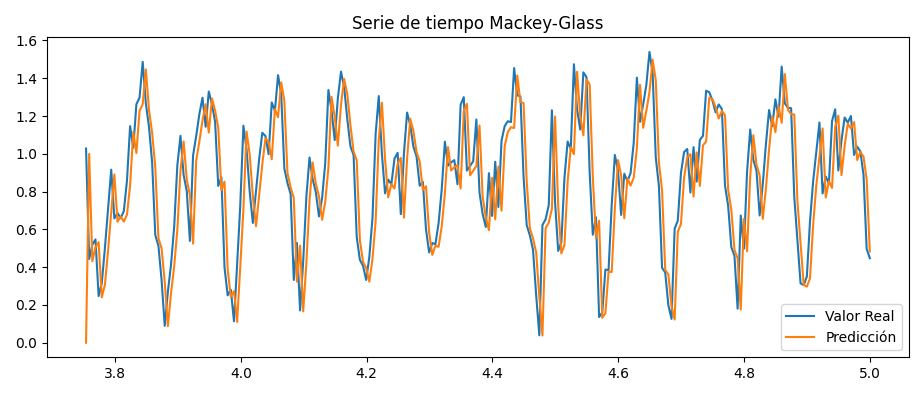

In [328]:
pred = np.zeros(len(y_valid))

for k in range(best_nlms.L, len(y_test)):
    pred[k] = best_nlms.predict(y_test[k-best_nlms.L:k])
    
fig, ax = plt.subplots(figsize=(6, 3), tight_layout=True)
ax.plot(t_test, y_test, label='Valor Real')
ax.plot(t_test, pred, label='Predicción')
ax.set_title('Serie de tiempo Mackey-Glass');
ax.legend();

<IPython.core.display.Javascript object>


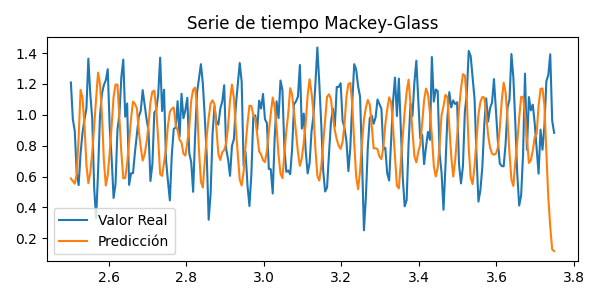

In [132]:
u_pred = np.convolve(myfilter.w,y_valid,'same')
    
fig, ax = plt.subplots(figsize=(6, 3), tight_layout=True)
ax.plot(t_valid, y_valid, label='Valor Real')
ax.plot(t_valid, u_pred, label='Predicción')
ax.set_title('Serie de tiempo Mackey-Glass');
ax.legend();

In [5]:
len(t_train)

500

1. Repita el paso anterior para el caso $\tau = 30$
1. Compare los resultados obtenidos con cada serie de tiempo ($\tau=17$ y $\tau=30$). Muestre la predicción en el conjunto de prueba versus su valor real. Muestre también los residuos. Discuta y analice sus resultados

## (45%) Predicción con algoritmo RLS

1. Describa en detalle el algoritmo RLS e implemente un predictor a un paso basado en el algoritmo RLS. Resalte las diferencias con el algoritmo LMS
1. Considere el caso $\tau=17$. Entrene su predictor en el conjunto de entrenamiento y encuentre la combinación de parámetros $\beta$ y $L$ que minimiza el NMSE en el conjunto de validación. Para $L$ pruebe al menos los siguientes valores [5, 10, 20, 30]. Comente sobre lo que observa.
1. Repita el paso anterior para el caso $\tau = 30$
1. Compare los resultados obtenidos con cada serie de tiempo. Muestre la predicción en el conjunto de prueba versus su valor real. Muestre también los residuos. Discuta y analice sus resultados

## (10%) Comparación entre LMS y RLS

1. Compare el mejor predictor LMS y RLS en el conjunto de test en términos de la calidad de la predicción y la velocidad a la que sigue los cambios. Comente y discuta
